In [1]:
# requisite modules: batman, numpy, matplotlib, lmfit, lightkurve, astropy

#1. Obtaining TESS data for π Mensae and search for planetary signatures
#2. Interpreting data with planetary transit model

# Related paper https://www.aanda.org/articles/aa/pdf/2018/11/aa34289-18.pdf

### 1. TESS data retrieval and apply BLS algorithm to find transits
based on  
https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-recover-first-tess-candidate.html  
https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html

In [2]:
import lightkurve as lk
import numpy as np
##https://www.aanda.org/articles/aa/full_html/2018/11/aa34289-18/aa34289-18.html

## data download
search_result = lk.search_targetpixelfile('Pi Mensae', mission='TESS', sector=1)
tpf = search_result.download(quality_bitmask='default')

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


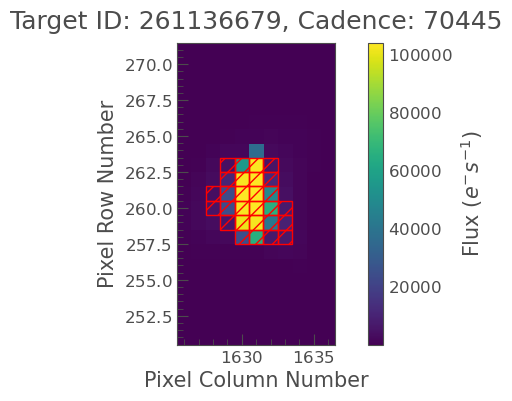

In [3]:
## aperture
tpf.plot(aperture_mask=tpf.pipeline_mask);

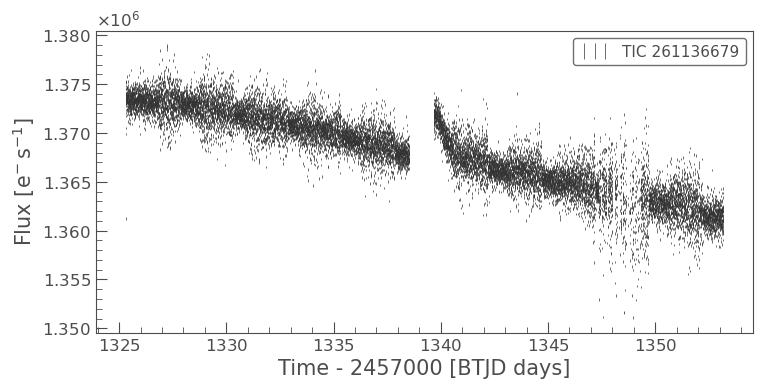

In [4]:
## tpf to lightcurve
lc = tpf.to_lightcurve()
lc.errorbar();



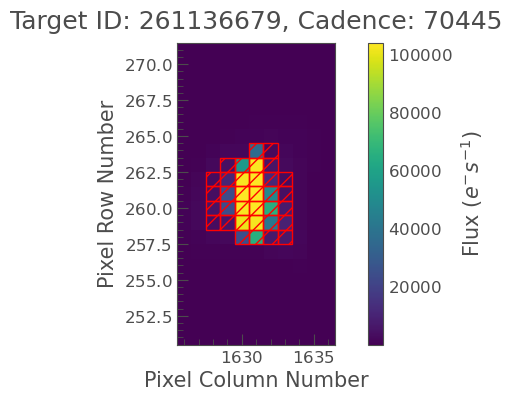

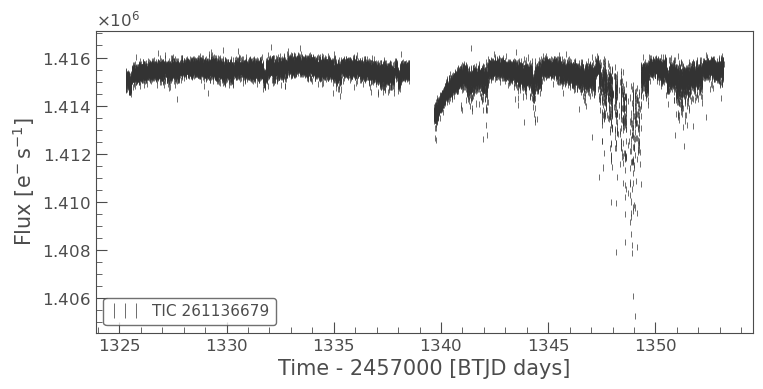

In [5]:
## make new aperture

aperture_mask = tpf.create_threshold_mask(threshold=10)

# Plot that aperture
tpf.plot(aperture_mask=aperture_mask);

## tpf to lightcurve
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.errorbar();

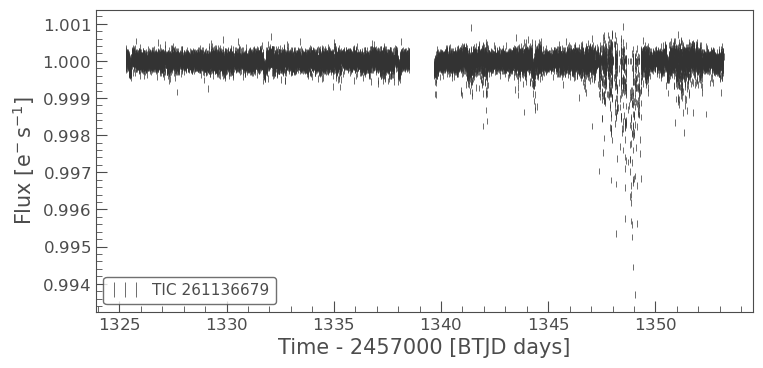

In [6]:
## flattening using Savitzky-Golay smoothing filter
## https://en.wikipedia.org/wiki/Savitzky–Golay_filter
flat_lc = lc.flatten(window_length=1001)
flat_lc.errorbar();

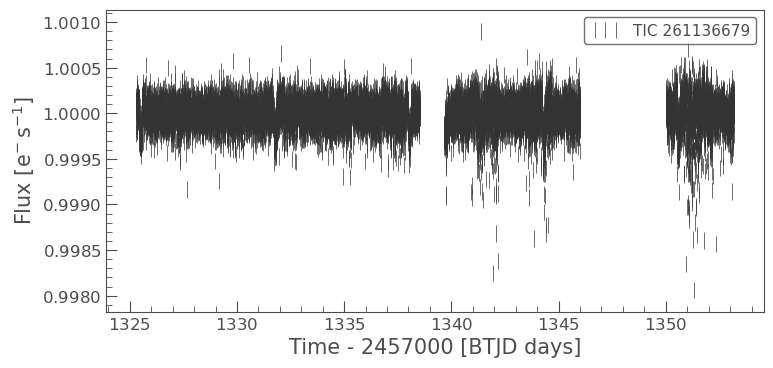

In [7]:
# Flag the times that are good quality
mask = (flat_lc.time.value < 1346) | (flat_lc.time.value > 1350)
masked_lc = flat_lc[mask]
masked_lc.errorbar();

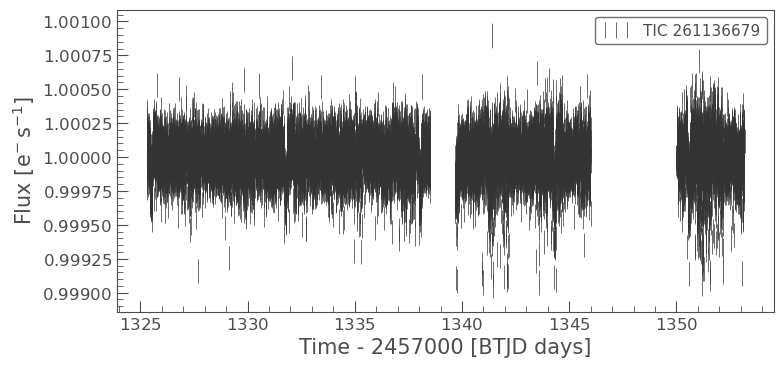

In [8]:
# Remove outliers
clipped_lc = masked_lc.remove_outliers(sigma=6)
clipped_lc.errorbar();

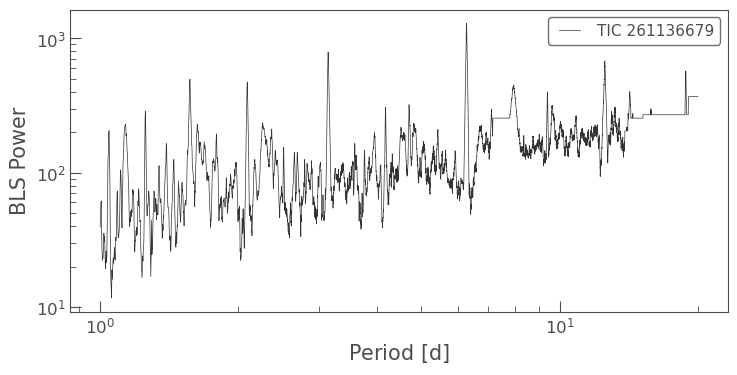

In [9]:
## BLS algorithm to search for transit signatures
## https://docs.astropy.org/en/stable/timeseries/bls.html

period = np.linspace(1, 20, 10000) ## search for periodic signlas with 1-20 days
bls = clipped_lc.to_periodogram(method='bls',period=period)#oversample_factor=1)
bls.plot(view='period', scale='log')
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

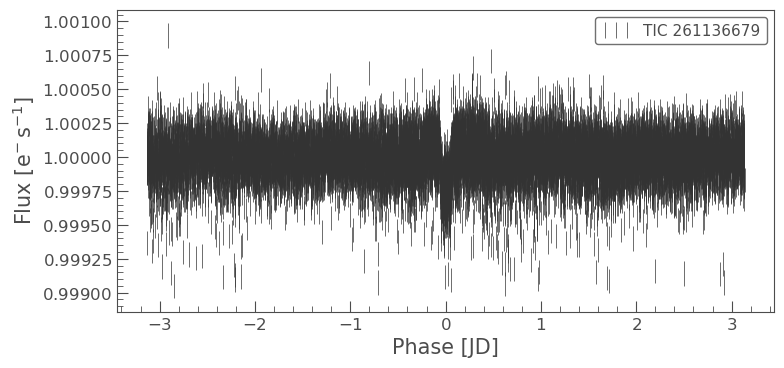

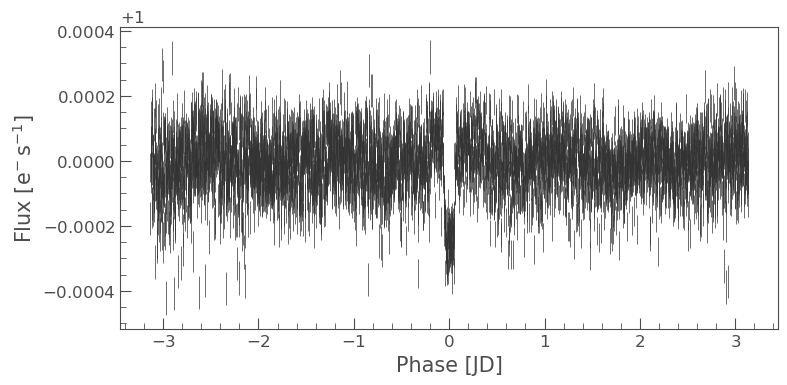

In [10]:
## Folding & binnning data based on BLS result
period = planet_b_period.value
folded_lc = clipped_lc.fold(period=period , epoch_time=planet_b_t0)
folded_lc.errorbar();

import astropy.units as u
binned_lc = folded_lc.bin(time_bin_size=2*u.minute)
binned_lc.errorbar();


In [11]:
## fitting transit lightcurve with model

In [12]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, random
import lmfit

def residual_transitfit(params, x, data, eps_data, names):
    params_batman = set_params_batman(params, names)
    m = batman.TransitModel(params_batman, x)    #initializes model
    model = m.light_curve(params_batman)         #calculates light curve
    return (data-model) / eps_data

def model_transitfit_from_lmparams(params, x, names):
    params_batman = set_params_batman(params, names)
    m = batman.TransitModel(params_batman, x)    #initializes model
    model = m.light_curve(params_batman)         #calculates light curve
    return model


def q_to_u_limb(q_arr):
    q1 = q_arr[0]
    q2 = q_arr[1]
    u1 = np.sqrt(q1) * 2 * q2
    u2 = np.sqrt(q1) * (1- 2 * q2)
    return np.array([u1, u2])

def set_params_batman(params_lm, names, limb_type ="quadratic"):
    
    params = batman.TransitParams()       #object to store transit parameters
    params.limb_dark =  limb_type        #limb darkening model
    q_arr = np.zeros(2)
    for i in range(len(names)):
        value = params_lm[names[i]]
        name = names[i]
        if name=="t0":
            params.t0 = value
        if name=="per":
            params.per = value         
        if name=="rp":
            params.rp = value
        if name=="a":
            params.a = value
        if name=="inc":
            params.inc = value               
        if name=="ecc":
            params.ecc = value          
        if name=="w":
            params.w = value  
        if name=="q1":
            q_arr[0] = value
        if name=="q2":
            q_arr[1] = value
    
    u_arr = q_to_u_limb(q_arr)
    params.u = u_arr
    return params

def set_params_lm(names, values, mins, maxes, vary_flags):
    params = lmfit.Parameters()
    for i in range(len(names)):
        if vary_flags[i]:
            params.add(names[i], value=values[i], min=mins[i], max = maxes[i], vary = vary_flags[i])
        else:
            params.add(names[i], value=values[i], vary = vary_flags[i])
    return params

## Data for fitting
time = np.array(binned_lc.time.value)
flux = np.array(binned_lc.flux.value)
flux_err = np.array(binned_lc.flux_err.value)
time_wd = 0.5 ## width of time window for fitting
flag = (time > -time_wd) * (time < time_wd)


names = ["t0", "per", "rp", "a", "inc", "ecc", "w", "q1", "q2"]
values = [0, period, 0.02, 10, 87, 0, 90, 0.3, 0.2]
mins = [-0.3, period, 0.001, 1, 70, 0, 90, 0.0, 0.0]
maxes = [0.3, period, 0.2, 100, 110, 0, 90, 1.0, 1.0]
vary_flags = [True, False, True, True, True, False, False, False, False]
params = set_params_lm(names, values, mins, maxes, vary_flags)

out = lmfit.minimize(residual_transitfit, params, args=(np.array(time[flag]), flux[flag], flux_err[flag], names))
print(lmfit.fit_report(out.params))



[[Variables]]
    t0:   8.9679e-05 +/- 9.1446e-04 (1019.70%) (init = 0)
    per:  6.271127 (fixed)
    rp:   0.01660087 +/- 9.0053e-04 (5.42%) (init = 0.02)
    a:    8.59090760 +/- 2.50030369 (29.10%) (init = 10)
    inc:  84.1957753 +/- 2.25905562 (2.68%) (init = 87)
    ecc:  0 (fixed)
    w:    90 (fixed)
    q1:   0.3 (fixed)
    q2:   0.2 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, inc)  =  1.000
    C(rp, inc) = -0.931
    C(rp, a)   = -0.929


(-0.3, 0.3)

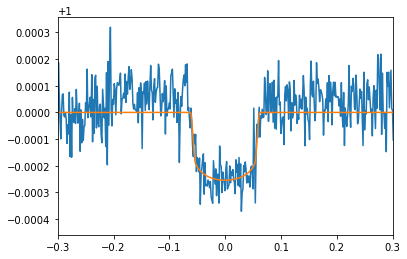

In [13]:
flux_model = model_transitfit_from_lmparams(out.params, time, names)
plt.plot(time, flux)
plt.plot(time, flux_model)
plt.xlim(-0.3,0.3)